Importamos la biblioteca Gymnassium, que vamos a usar como framework de RL

In [3]:
!pip3 install cmake gymnasium scipy
import gymnasium as gym

Creamos un ambiente y lo mostramos en pantalla. Para esto definimos una función para imprimir nuestro ambiente.

In [4]:
# La semilla usada para crear el ambiente
semilla = 1

entorno = gym.make("Taxi-v3", render_mode='ansi').env
entorno.reset(seed = semilla)

# Una funcion de ayuda para imprimir el estado de nuestro mundo
def print_env(estado):
  env_str = estado.render()
  print(env_str)

print_env(entorno)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+





El rectángulo de color representa el taxi, amarillo cuando va sin pasajero y verde con pasajero.
'|' representa una pared que el taxi no puede cruzar, es decir.
R, G, Y, B son los puntos de interés, es decir, las posibles ubicaciones de recogida y destino. La letra azul representa la ubicación actual de recogida de pasajeros, y la letra púrpura es el destino actual.

Si cambiamos la semilla, cambia el estado del ambiente.

In [5]:
# Una semilla diferente
semilla = 2

entorno = gym.make("Taxi-v3", render_mode='ansi').env
entorno.reset(seed = semilla)

print_env(entorno)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




Exploremos el espacio de estados y de acciones:

In [6]:
print(f"Espacio de Acciones {entorno.action_space}")
print(f"Espacio de Estados {entorno.observation_space}")

Espacio de Acciones Discrete(6)
Espacio de Estados Discrete(500)


Hay 6 acciones, que corresponden a:
 * 0 = ir al Sur
 * 1 = ir al Norte
 * 2 = ir al Este
 * 3 = ir al Oeste
 * 4 = recoger pasajero
 * 5 = dejar pasajero

Los puntos cardinales siguen la convención Norte hacie arriba. Recoger/dejar al pasajero solo tienen efecto si el taxi está en la misma casilla que el pasajero, y en uno de los puntos de interés.

Nuestro agente deberá elegir la acción a tomar en cada paso. Gymnassium nos expone funciones para esto. Si queremos movernos al sur, por ejemplo:

In [7]:
semilla = 1
entorno = gym.make("Taxi-v3", render_mode='ansi').env
entorno.reset(seed = semilla)
print_env(entorno)

accion = 0 # Sur
entorno.step(accion)

print_env(entorno)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)



Ahora estamos listos para programar un agente. Empezando por uno random. Se puede ejecutar el codigo abajo varias veces para ver como cambia en cada ejecución, debido a que la semilla_acciones es diferente.

In [8]:
import random 

def episodio_random(semilla_ambiente = 1):
    entorno = gym.make("Taxi-v3", render_mode='ansi').env
    entorno.reset(seed = semilla_ambiente)

    iteraciones = 0
    penalizaciones, recompensa = 0, 0

    marcos = [] # para la animación

    termino = False
    truncado = False

    while not termino and not truncado:
        #  selecciona una acción aleatoria del conjunto de todas las posibles acciones
        accion = entorno.action_space.sample() 
        estado, recompensa, termino, truncado, info = entorno.step(accion)

        # El agente trato de dejar/recoger al pasajero incorrectamente
        if recompensa == -10:
            penalizaciones += 1

        # Put each rendered frame into dict for animation
        marcos.append({
            'marco': entorno.render(),
            'estado': estado,
            'accion': accion,
            'recompensa': recompensa
            }
        )

        iteraciones += 1


    print("Iteraciones: ",iteraciones)
    print("Penalizaciones: ", penalizaciones)

    return marcos

marcos = episodio_random()

Iteraciones:  7840
Penalizaciones:  2591


Podemos ver el episodio completo abajo. Notar que seleccionamos la semillia de selector de acciones para que la corrida sea 'buena'.

In [9]:
from IPython.display import clear_output
from time import sleep
import sys

def print_frames(marcos):
    for i, marco in enumerate(marcos):
        clear_output()
        print(marco['marco'])
        print(f"Iteracion: {i + 1}")
        print(f"Estado: {marco['estado']}")
        print(f"Accion: {marco['accion']}")
        print(f"Recompensa: {marco['recompensa']}")
        sys.stdout.flush()
        # Aumentar este tiempo para ver mejor la animación
        sleep(.01)

print_frames(marcos)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Iteracion: 7840
Estado: 0
Accion: 5
Recompensa: 20


Ahora queremos programar un agente inteligente, para eso nos vamos a atener a la siguiente interfaz.

In [10]:
class Agente:
    def elegir_accion(self, estado, max_accion) -> int: 
        """Elegir la accion a tomar en el estado actual y el espacio de acciones"""
        pass

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa): 
        """Aprender a partir de la tupla 
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
        """
        pass

Para nuestro agente aleatorio, esto sería:

In [11]:
import random

class AgenteAleatorio(Agente):
    def elegir_accion(self, estado, max_accion) -> int:
        # Elige una acción al azar
        return random.randrange(max_accion)

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa):
        # No aprende
        pass

Poniendolo a jugar:

In [12]:
semilla = 1
entorno = gym.make("Taxi-v3", render_mode='ansi').env

agente = AgenteAleatorio()

iteraciones = 0
penalizaciones, recompensa = 0, 0

marcos = [] # for animation

termino = False
truncado = False
estado_anterior, info = entorno.reset(seed = semilla)
while not termino and not truncado:
    # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
    accion = agente.elegir_accion(estado_anterior, entorno.action_space.n)
    # Realizamos la accion
    estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
    # Le informamos al agente para que aprenda
    agente.aprender(estado_anterior, estado_siguiente, accion, recompensa)

    # El agente trato de dejar/recoger al pasajero incorrectamente
    if recompensa == -10:
        penalizaciones += 1

    # Put each rendered frame into dict for animation
    marcos.append({
        'marco': entorno.render(),
        'estado': estado_siguiente,
        'accion': accion,
        'recompensa': recompensa
        }
    )

    estado_anterior = estado_siguiente
    iteraciones += 1


print(f"Iteraciones: {iteraciones}")
print(f"Penalizaciones: {penalizaciones}")

Iteraciones: 1763
Penalizaciones: 560


Podemos encapsular lo anterior en una función 

In [13]:
range(entorno.action_space.n-1)

range(0, 5)

In [14]:
def ejecutar_episodio(agente, semilla):
    entorno = gym.make("Taxi-v3", render_mode='ansi').env

    iteraciones = 0
    penalizaciones, recompensa = 0, 0

    marcos = [] # for animation

    termino = False
    truncado = False
    estado_anterior, info = entorno.reset(seed = semilla)
    while not termino and not truncado:
        # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
        accion = agente.elegir_accion(estado_anterior, entorno.action_space.n)
        # Realizamos la accion
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        # Le informamos al agente para que aprenda
        agente.aprender(estado_anterior, estado_siguiente, accion, recompensa)

        # El agente trato de dejar/recoger al pasajero incorrectamente
        if recompensa == -10:
            penalizaciones += 1

        # Put each rendered frame into dict for animation
        marcos.append({
            'marco': entorno.render(),
            'estado': estado_siguiente,
            'accion': accion,
            'recompensa': recompensa
            }
        )

        estado_anterior = estado_siguiente
        iteraciones += 1
    return iteraciones


y correrlo varias veces para ver el rendimiento promedio

In [15]:
agente = AgenteAleatorio()
semilla = 1
num_iteraciones_episodios = []
for i in range(10):
    num_iteraciones = ejecutar_episodio(agente, semilla)
    num_iteraciones_episodios += [num_iteraciones]

Y obtener métricas al respecto

In [16]:
import numpy
print(f"Se realizaron {numpy.mean(num_iteraciones_episodios)}, en promedio")

Se realizaron 1463.2, en promedio


La tarea a realizar consiste en programar un agente de aprendizaje por refuerzos:

In [17]:
import numpy as np
import random

class AgenteRL(Agente):
    def __init__(self, entorno, alpha=0.1, gamma=0.9, epsilon=0.1) -> None:
        super().__init__()
        self.entorno = entorno
        self.alpha = alpha  # Tasa de aprendizaje
        self.gamma = gamma  # Factor de descuento
        self.epsilon = epsilon  # Probabilidad de exploración

        # Inicializa la tabla Q con valores aleatorios
        self.num_acciones = entorno.action_space.n
        self.num_estados = entorno.observation_space.n
        self.Q = np.random.uniform(low=-1, high=1, size=(self.num_estados, self.num_acciones))

    def elegir_accion(self, estado, max_accion) -> int:
        # Selección de acción epsilon-greedy
        if random.uniform(0, 1) < self.epsilon:
            return self.entorno.action_space.sample()  # Acción aleatoria
        else:
            return np.argmax(self.Q[estado, :])  # Acción con el valor máximo de Q

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa):
        # Actualiza la tabla Q usando la regla de Q-Learning
        valor_actual = self.Q[estado_anterior, accion]
        max_valor_siguiente = np.max(self.Q[estado_siguiente, :])
        nuevo_valor = (1 - self.alpha) * valor_actual + self.alpha * (recompensa + self.gamma * max_valor_siguiente)
        self.Q[estado_anterior, accion] = nuevo_valor

Y ejecutar con el muchos episodios con la misma semilla:

In [18]:
agente = AgenteRL(entorno)
semilla = 1
num_iteraciones_episodios = []
for i in range(1000):
    num_iteraciones = ejecutar_episodio(agente, semilla)
    num_iteraciones_episodios.append(num_iteraciones)

promedio_iteraciones = np.mean(num_iteraciones_episodios)
print(f"Se realizaron {promedio_iteraciones} en promedio.")

Se realizaron 25.387 en promedio.


In [19]:
#!pip install matplotlib
import matplotlib.pyplot as plt


In [64]:
import pandas as pd

def split_matrix_plot(matrix, num_splits):

    # Calculate the number of rows in each submatrix
    num_rows = len(matrix) // num_splits

    # Create a list to store the submatrices as DataFrames
    submatrices = []

    # Split the long matrix into submatrices
    for i in range(num_splits):
        start_row = i * num_rows
        end_row = start_row + num_rows
        submatrix_data = matrix[start_row:end_row, :]
        submatrix_df = pd.DataFrame(submatrix_data, columns=['Sur', 'Norte', 'Este', 'Oeste', 'Recoger', 'Dejar']) 
        submatrix_df.index = range(start_row, end_row)
        submatrices.append(submatrix_df)
    return submatrices

def grilla_plot(submatrices, num_rows , num_cols, colormap = 'viridis'):
    if len(submatrices) <= num_rows * num_cols:
        # Assuming 'submatrices' is a list of DataFrames
        num_plots = len(submatrices)

        # Define the layout of subplots (3 rows and 2 columns)
        num_rows = 3
        num_cols = 2

        # Calculate the total number of subplots required
        num_subplots = num_rows * num_cols

        # Create a figure with the specified number of subplots
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

        # Flatten the axes array for easy iteration
        axes = axes.flatten()

        # Loop through the submatrices and plot them
        for i, submatrix in enumerate(submatrices):
            if i < num_subplots:
                ax = axes[i]
                sns.heatmap(submatrix, cmap=colormap, ax=ax)
                ax.set_title(f'Heatmap {i + 1}')

        # Hide any remaining empty subplots
        for i in range(num_subplots, num_plots):
            axes[i].axis('off')

        # Adjust spacing between subplots
        plt.tight_layout()

        # Show the plot
        plt.show()

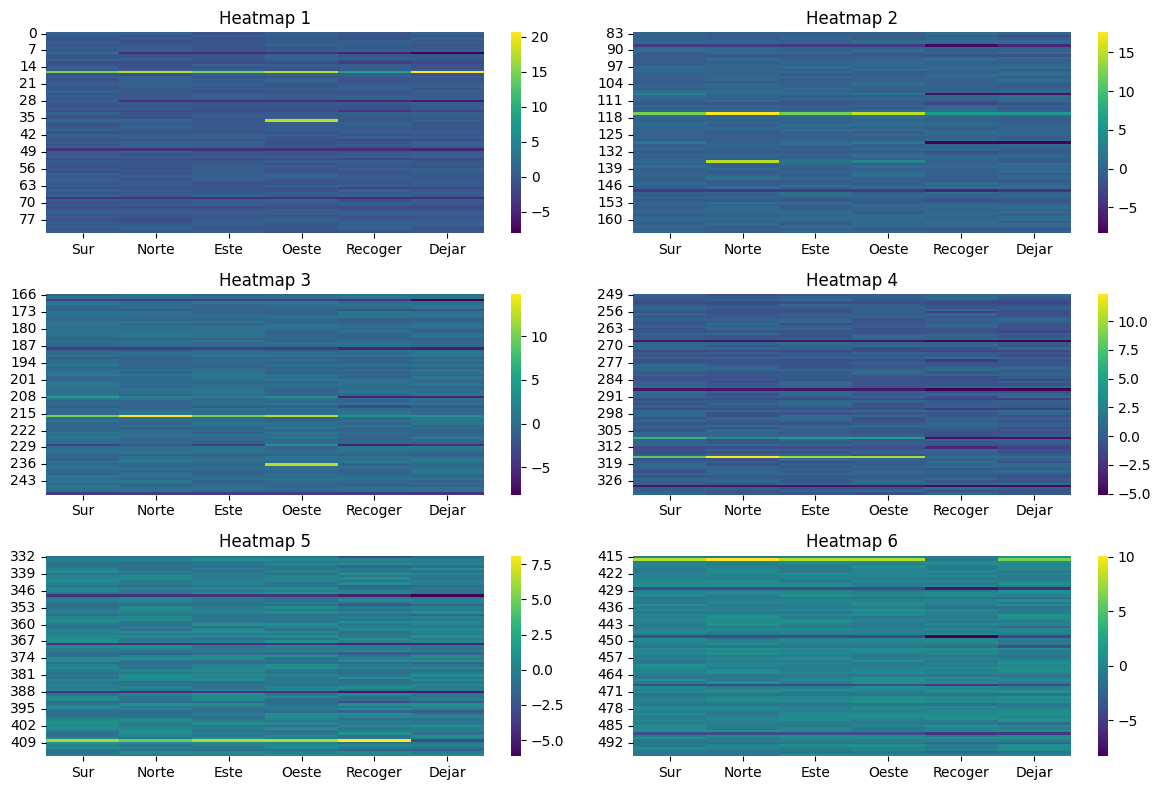

In [65]:
submatrices1 = split_matrix_plot(agente.Q, 6)
grilla_plot(submatrices1, 2 , 3)

Ejecutando con semilla = 2

In [66]:
agente2 = AgenteRL(entorno)
semilla = 2
num_iteraciones_episodios = []
for i in range(1000):
    num_iteraciones = ejecutar_episodio(agente, semilla)
    num_iteraciones_episodios.append(num_iteraciones)

promedio_iteraciones = np.mean(num_iteraciones_episodios)
print(f"Se realizaron {promedio_iteraciones} en promedio.")

Se realizaron 11.257 en promedio.


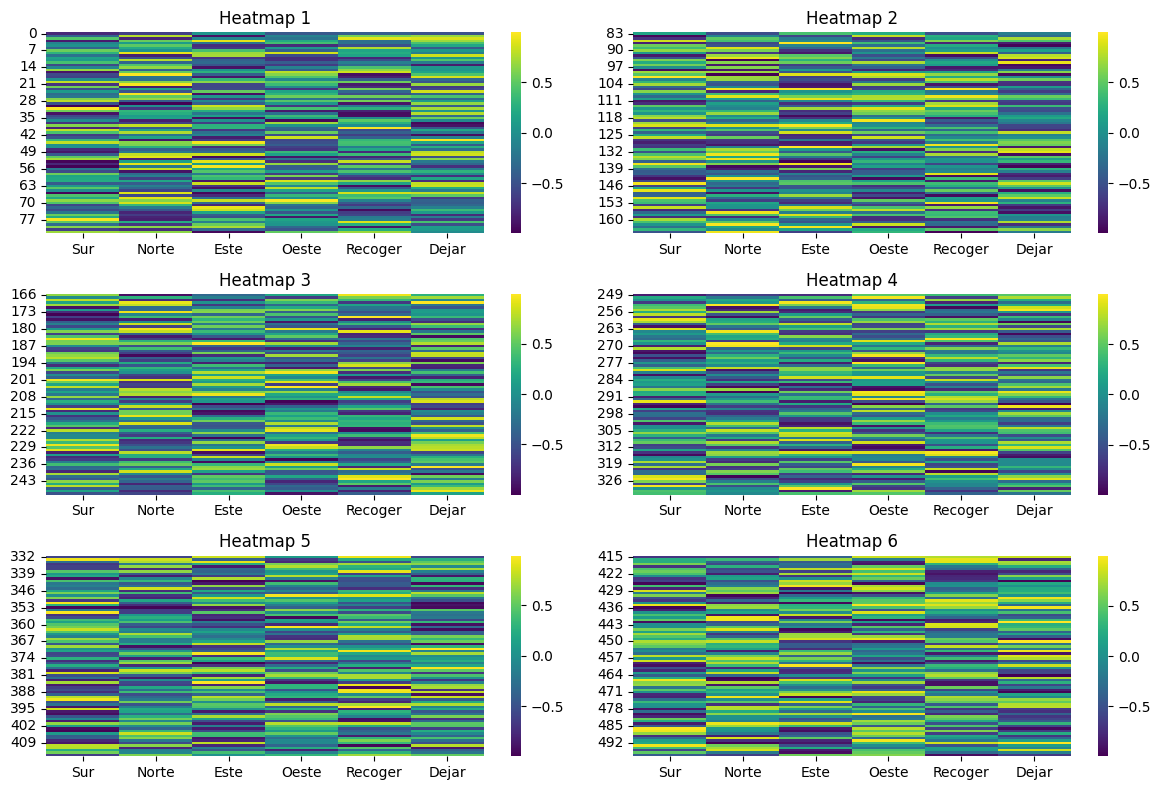

In [67]:
submatrices2 = split_matrix_plot(agente2.Q, 6)
grilla_plot(submatrices2, 2 , 3)

Analizar los resultados de la ejecución anterior.

In [23]:
# Analizar los resultados aqui


Se mantiene el rendimiento si cambiamos la semilla? Por qué?

In [24]:
# Agregar código aqui

Podemos mejorar el agente para que se desempeñe bien usando cualquier semilla?

In [25]:

# Agregar código aqui
